In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from nltk.corpus import stopwords
from collections import Counter

import string
import re

import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")


GPU is available


In [ ]:
df = pd.read_csv('/content/IMDB Dataset.csv')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
X = df['review'].values
y = df['sentiment'].values

In [ ]:
X.shape, y.shape

((50000,), (50000,))

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)

In [ ]:
X_train.shape,X_test.shape

((37500,), (12500,))

In [ ]:
type(X_train),type(X_test)

(numpy.ndarray, numpy.ndarray)

# Analysis the sentiment:

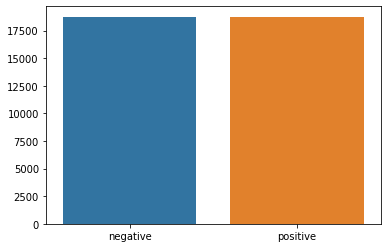

In [ ]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x = np.array(['negative','positive']),
           y = dd.values)
plt.show()

# Data Prepocessing:

In [ ]:
def preprocessing_text(text):
    # extracting only words not other than words:
    text = re.sub(r'[^\w\s]', '', text)
    # and removing all whitespace from the every sentencs:
    text = re.sub(r'\s+', '', text)
    # removing the digit from the every sentences:
    text = re.sub(r'\d+', '', text)
    
    # return the whole text:
    return text


def tokenized(X_train, y_train, X_val, y_val):
    
    word_list = []
    
    stop_words = set(stopwords.words('english'))
    for sent in X_train:
        for word in sent.lower().split():
            word = preprocessing_text(word)
            
            if word not in stop_words and word != '':
                word_list.append(word)
    
    corpus = Counter(word_list)
    # sorting on the basis of most common words:
    corpus_ = sorted(corpus, key = corpus.get, reverse = True)[:1000]
    
    # creating a dict:
    onehot_dict = {w:i+1 for i, w in enumerate(corpus_)}
    
    
    # tokenize
    final_list_train, final_list_test = [], []
    
    for sent in X_train:
        final_list_train.append([onehot_dict[preprocessing_text(word)] for word in sent.lower().split()
                                if preprocessing_text(word) in onehot_dict.keys()])
        
    for sent in X_val:
        final_list_test.append([onehot_dict[preprocessing_text(word)] for word in sent.lower().split()
                               if preprocessing_text(word) in onehot_dict.keys()])
        
    encoded_train = [1 if label == 'positive' else 0 for label in y_train]
    encoded_test = [1 if label == 'positive' else 0 for label in y_val]
    
    return np.array(final_list_train), np.array(encoded_train), np.array(final_list_test), np.array(encoded_test), onehot_dict

In [ ]:
X_train, y_train, X_test, y_test, vocab = tokenized(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
X_train.shape,y_train.shape

((37500,), (37500,))

In [ ]:
X_test.shape, y_test.shape

((12500,), (12500,))

In [ ]:
print(f' length of vocabulary is{len(vocab)}')

 length of vocabulary is1000


# Analysis of Rewiew Length:

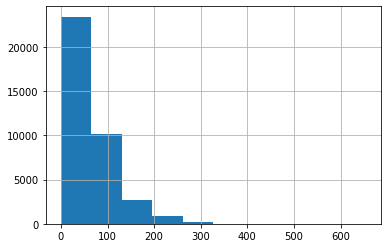

In [ ]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist()
plt.show()

In [ ]:
pd.Series(rev_len).describe()

count    37500.000000
mean        69.290773
std         48.087338
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        653.000000
dtype: float64

# Padding:

In [ ]:
def padding(sentences, seq_len):
    
    features = np.zeros((len(sentences), seq_len), dtype = int)
    
    for i, review in enumerate(sentences):
        if len(review) != 0:
            features[i, -len(review):] = np.array(review)[:seq_len]
            
    return features

In [ ]:
X_train_pad = padding(X_train, 500)
X_test_pad = padding(X_test, 500)

In [ ]:
X_train_pad.shape,y_train.shape

((37500, 500), (37500,))

In [ ]:
X_test_pad.shape,y_test.shape

((12500, 500), (12500,))

# Batching and Loading as tensor:

In [ ]:
# create tensor datasets:
# for training data:
train_data = TensorDataset(torch.from_numpy(X_train_pad),torch.from_numpy(y_train))

# for validate data:
valid_data = TensorDataset(torch.from_numpy(X_test_pad), torch.from_numpy(y_test))

# dataloaders:
batch_size = 50

# make sure to shuffle your data:
train_loader = DataLoader(train_data, shuffle = True, batch_size = batch_size)

valid_loader = DataLoader(valid_data, shuffle = True, batch_size = batch_size)


In [ ]:
# obtain one batch of training data:
dataiter = iter(train_loader)
# create a sample of the data from the train_loader:
sample_x, sample_y = dataiter.next()

In [ ]:
sample_x.size()

torch.Size([50, 500])

In [ ]:
sample_y.size()

torch.Size([50])

# Model: 

In [ ]:
class SentimentLSTM(nn.Module):
    """
        This is RNN model for sentiment analysis:
    """
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob = 0.5):
        
        """
            Parameters:
                
                output_dim : this is the output size of your LSTM model.
                no_layers : how much layers are used for the LSTM.
                vocab_size : what is your vocabulary size which you are perfroming the sentiment analysis.
                hidden_layers : no of hidden layers is the LSTM model.
                embedding_dim : how much dimension you are finding the correlation with given text.
        """
        
        super(SentimentLSTM, self).__init__()
        
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        
        # Embedding:
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layers:
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, no_layers, batch_first = True)
        
        # dorpout:
        self.dropout = nn.Dropout(0.3)
        
        # linear
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # sigmoid layer:
        self.sigmoid = nn.Sigmoid()
        
        
    """
    forward pass of our LSTM model:
    """
    
    def forward(self, x, hidden):
        """
        parameters : 
          
          x = input_text which we are providing our LSTM model.
          hidden = no of hidden layers present.
        """
        
        # batch_size:
        batch_size = x.size(0)
        
        # embedding:
        embeds = self.embedding(x)
        
        # lstm:
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout:
        out = self.dropout(lstm_out)
        
        # fully connected layer:
        out = self.fc(out)
        
        # sigmoid fun:
        sig_out = self.sigmoid(out)
        
        # reshape according to batch size:
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        
        # return sig_out and hidden:
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        """
          initializes hidden state:
        """
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        
        hidden = (h0, c0)
        return hidden

# Initalization of parameters:

In [ ]:
no_layers = 2
vocab_size = len(vocab) + 1 # 1 for padding:
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentLSTM(no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob = 0.5)
model.to(device)

SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# Training:

In [ ]:
# loss and optimization function:

lr = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)


# function for predict the accuracy:
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
clip = 5
epochs = 5
valid_loss_min = np.Inf

# train for some number of epochs:

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []


for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    
    # this steps for the training of Train_data:
    # initalize hiddens state:
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Creating new variables for the hidden state, otherwise
        # we did backprop throught the entire training history
        h = tuple([each.data for each in h])
        model.zero_grad()
        output, h = model(inputs, h)
        
        # Calcualte the loss and perfrom backprop:
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        
        # Calculate Accuracy:
        accuracy = acc(output, labels)
        train_acc += accuracy
        
        # clip_grad_norm helping for preventing the exploding gradient problem in RNN and LSTM:
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    # this steps for training the Val_data:    
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
       
        val_h = tuple([each.data for each in val_h])
        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())
        val_losses.append(val_loss.item())
        accuracy = acc(output, labels)
        val_acc += accuracy
        
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch : {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '/content/State_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
        print(25*'==')

Epoch : 1
train_loss : 0.5073404076099396 val_loss : 0.4278122979402542
train_accuracy : 75.58666666666667 val_accuracy : 81.328
Validation loss decreased (inf --> 0.427812).  Saving model ...
Epoch : 2
train_loss : 0.3825977258682251 val_loss : 0.37727468621730803
train_accuracy : 83.82666666666667 val_accuracy : 84.112
Validation loss decreased (0.427812 --> 0.377275).  Saving model ...
Epoch : 3
train_loss : 0.3328415018220743 val_loss : 0.34067435312271116
train_accuracy : 86.11999999999999 val_accuracy : 85.312
Validation loss decreased (0.377275 --> 0.340674).  Saving model ...
Epoch : 4
train_loss : 0.3015322875479857 val_loss : 0.3323649041056633
train_accuracy : 87.62133333333333 val_accuracy : 85.624
Validation loss decreased (0.340674 --> 0.332365).  Saving model ...
Epoch : 5
train_loss : 0.26683218133946257 val_loss : 0.34179583078622816
train_accuracy : 89.15466666666667 val_accuracy : 85.408


In [ ]:
# visulization

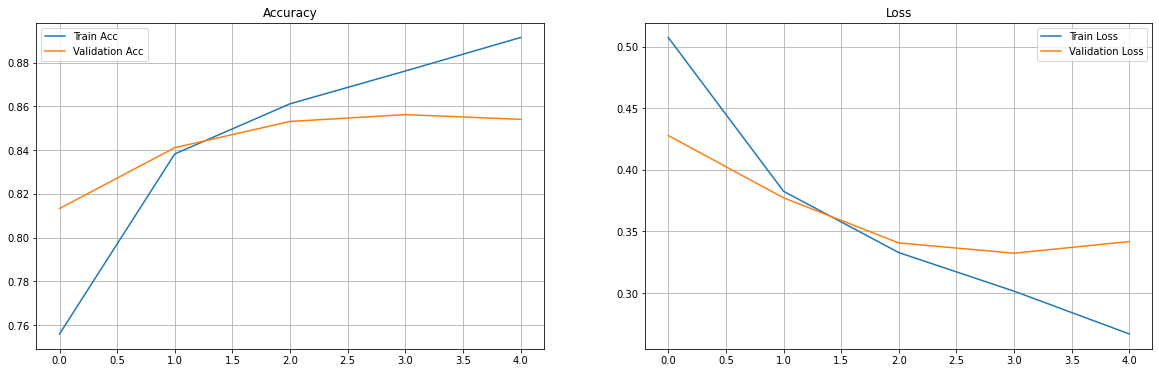

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label = 'Train Acc')
plt.plot(epoch_vl_acc, label = 'Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label = 'Train Loss')
plt.plot(epoch_vl_loss, label = 'Validation Loss')
plt.title("Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Predict text:

In [ ]:
def predict_text(text):

  word_seq = np.array([vocab[preprocessing_text(word)] for word in text.split() 
  if preprocessing_text(word) in vocab.keys()])

  word_seq = np.expand_dims(word_seq, axis = 0)
  pad = torch.from_numpy(padding(word_seq, 500))
  inputs = pad.to(device)
  batch_size = 1
  h = model.init_hidden(batch_size)
  h = tuple([each.data for each in h])
  output, h = model(inputs, h)
  return (output.item())

In [ ]:
index = 30
print(df['review'][index])
print('='*70)
print(f"actual sentiment is : {df['sentiment'][index]}")
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, howeve